In [1]:
import numpy as np
import pandas as pd
import re

#Visualisation Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from pandas.plotting import scatter_matrix

#Training and Preprocessing Libraries
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

# sampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN

# classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

In [2]:
class_dict = {'Fatal': 1, 'Severe': 2, 'Slight': 3}
class_labels = ['Fatal', 'Severe', 'Slight']
#1 = Fatal, 
#2 = Serious, 
#3 = Slight


In [3]:
data1 = pd.read_csv("./data/accidents_2005_to_2007.csv")
data2 = pd.read_csv("./data/accidents_2009_to_2011.csv")
data3 = pd.read_csv("./data/accidents_2012_to_2014.csv")

In [4]:
data = pd.concat([data1, data2, data3])


In [5]:
# type(data)
# print(data.head(0))

In [6]:
# def max_val(s):
#     is_max = s == s.max()
#     return ['background-color: yellow' if v else '' for v in is_max]

# year_wise_casualties = data.groupby(['Year'])['Number_of_Casualties'].sum()
# year_wise_casualties = year_wise_casualties.reset_index()
# year_wise_casualties = year_wise_casualties.style.apply(max_val, axis=0)
# year_wise_casualties

In [7]:
# cas_table = data.groupby(['Day_of_Week']).agg({'Number_of_Casualties':['sum'],'Speed_limit':['min','max']})
# cas_table = cas_table.sort_values([('Number_of_Casualties','sum')],ascending=False)
# cas_table = cas_table.reset_index()
# cas_table.style.apply(max_val)

In [8]:
# corr_matrix = data.corr()
# corr_matrix["Accident_Severity"].sort_values(ascending=False)

In [9]:
# 30/11/2007
def convert_date_to_day_of_year(dt):
    result = re.findall(r'(\d{2})/(\d{2})/(\d{4})',dt)
    return result[0][0]
   
def convert_date_to_month(dt):
    result = re.findall(r'(\d{2})/(\d{2})/(\d{4})',dt)
    return result[0][1]

In [10]:
data['day_of_year'] = data.Date.apply(lambda x: convert_date_to_day_of_year(x))
data['month'] = data.Date.apply(lambda x: convert_date_to_month(x))


In [11]:
drop_columns = ['Date', 'Accident_Index', 'Number_of_Casualties', 'Police_Force', 'Junction_Detail', 'Junction_Control', 'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Did_Police_Officer_Attend_Scene_of_Accident', 'LSOA_of_Accident_Location', 'Local_Authority_(District)', 'Local_Authority_(Highway)']

In [12]:
data1 = data.drop(drop_columns, axis=1, inplace=False)
data1.dropna(inplace=True)

In [13]:
#Drop rows with 'Unknown' values
data1 = data1[data1.Weather_Conditions!='Unknown']
data1 = data1[data1.Road_Type!='Unknown']

In [14]:
#Encode "String" Labels into "Int" Labels for easy training
le_Pedestrian_Crossing_Physical_Facilities = LabelEncoder()
le_Light_Conditions = LabelEncoder()
le_Weather_Conditions = LabelEncoder()
le_Road_Surface_Conditions = LabelEncoder()
le_Pedestrian_Crossing_Human_Control = LabelEncoder()
le_Road_Type = LabelEncoder()


le_Pedestrian_Crossing_Physical_Facilities.fit(data1["Pedestrian_Crossing-Physical_Facilities"])
le_Light_Conditions.fit(data1["Light_Conditions"])
le_Weather_Conditions.fit(data1["Weather_Conditions"])
le_Road_Surface_Conditions.fit(data1["Road_Surface_Conditions"])
le_Pedestrian_Crossing_Human_Control.fit(data1["Pedestrian_Crossing-Human_Control"])
le_Road_Type.fit(data1["Road_Type"])

LabelEncoder()

In [15]:
def preprocess_time(temp_data):
    temp_data["Pedestrian_Crossing-Physical_Facilities"]= le_Pedestrian_Crossing_Physical_Facilities.transform(temp_data["Pedestrian_Crossing-Physical_Facilities"])
    temp_data["Light_Conditions"]= le_Light_Conditions.transform(temp_data["Light_Conditions"])
    temp_data["Weather_Conditions"] = le_Weather_Conditions.transform(temp_data["Weather_Conditions"])
    temp_data["Road_Surface_Conditions"] = le_Road_Surface_Conditions.transform(temp_data["Road_Surface_Conditions"])
    temp_data["Pedestrian_Crossing-Human_Control"] = le_Pedestrian_Crossing_Human_Control.transform(temp_data["Pedestrian_Crossing-Human_Control"])
    temp_data["Road_Type"] = le_Road_Type.transform(temp_data["Road_Type"])
    temp_data["Time"]= temp_data["Time"].astype(str)
    temp_data['Time']= temp_data['Time'].str.slice(0,2,1)
    temp_data["Time"]= temp_data["Time"].astype(int)
    return temp_data

In [16]:
data1 = preprocess_time(data1)

In [17]:
# le_Light_Conditions.classes_
# data1["Light_Conditions"]
# le_Light_Conditions.transform(data1["Light_Conditions"])

In [18]:
train,test = train_test_split(data1,test_size=.20)

In [19]:
features = ["Longitude", "Latitude", "Number_of_Vehicles", "Day_of_Week", "Time", "Road_Type", "Speed_limit", "Pedestrian_Crossing-Human_Control", "Pedestrian_Crossing-Physical_Facilities", "Light_Conditions", "Weather_Conditions", "Road_Surface_Conditions","Year", "day_of_year", "month", "Urban_or_Rural_Area"]
# train_features = train[["Longitude", "Latitude", "Number_of_Vehicles", "Day_of_Week", "Time", "Road_Type", "Speed_limit", "Pedestrian_Crossing-Human_Control", "Pedestrian_Crossing-Physical_Facilities", "Light_Conditions", "Weather_Conditions", "Road_Surface_Conditions","Year", "day_of_year", "month", "Urban_or_Rural_Area"]]
# test_features =test[["Longitude", "Latitude", "Number_of_Vehicles", "Day_of_Week", "Time", "Road_Type", "Speed_limit", "Pedestrian_Crossing-Human_Control", "Pedestrian_Crossing-Physical_Facilities", "Light_Conditions", "Weather_Conditions", "Road_Surface_Conditions","Year", "day_of_year", "month", "Urban_or_Rural_Area"]]


# features = ["Number_of_Vehicles", "Day_of_Week", "Time", "Road_Type", "Speed_limit", "Pedestrian_Crossing-Human_Control", "Pedestrian_Crossing-Physical_Facilities", "Light_Conditions", "Weather_Conditions", "Road_Surface_Conditions","month", "Urban_or_Rural_Area"]
# train_features = train[[ "Number_of_Vehicles", "Day_of_Week", "Time", "Road_Type", "Speed_limit", "Pedestrian_Crossing-Human_Control", "Pedestrian_Crossing-Physical_Facilities", "Light_Conditions", "Weather_Conditions", "Road_Surface_Conditions", "month", "Urban_or_Rural_Area"]]
# test_features =test[["Number_of_Vehicles", "Day_of_Week", "Time", "Road_Type", "Speed_limit", "Pedestrian_Crossing-Human_Control", "Pedestrian_Crossing-Physical_Facilities", "Light_Conditions", "Weather_Conditions", "Road_Surface_Conditions","month", "Urban_or_Rural_Area"]]


In [20]:
# predicted_classes = []

In [21]:
# print(train.shape)
# train.head(0)

In [22]:
y_train = train['Accident_Severity']
# x_train = train.loc[:, train.columns != 'Accident_Severity']
x_train = train[features]


In [23]:
# y_train

In [24]:
y_test = test['Accident_Severity'] 
# x_test = test.loc[:, train.columns != 'Accident_Severity']
x_test = test[features]

In [25]:
print(test.loc[:, x_train.columns != 'Accident_Severity'].head(0))

Empty DataFrame
Columns: [Location_Easting_OSGR, Location_Northing_OSGR, Longitude, Latitude, Accident_Severity, Number_of_Vehicles, Day_of_Week, Time, 1st_Road_Class, 1st_Road_Number, Road_Type, Speed_limit]
Index: []


In [26]:
print("x_train: ", x_train.shape)
print("x_test: ", x_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

x_train:  (1174393, 12)
x_test:  (293599, 12)
y_train:  (1174393,)
y_test:  (293599,)


,Number_of_Vehicles,Day_of_Week,Time,Road_Type,Speed_limit,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,month,Urban_or_Rural_Area


In [27]:
# print(y_test[1:10], y_train[1:10])

In [28]:
# ros = RandomOverSampler(random_state=0)
# x_resampled, y_resampled = ros.fit_resample(x_train, y_train)
# x_resampled, y_resampled = SMOTE().fit_resample(x_train, y_train)


In [29]:
# print(x_resampled.shape, y_resampled.shape)

(2994504, 12) (2994504,)


In [30]:
def build_model(clf, X_train, Y_train):
    print(clf)
    clf.fit(X_train, Y_train)
    return clf

In [31]:
def predict(clf, X_test):
    pred = clf.predict(X_test)
    return pred

In [32]:
def print_score(y_test, pred, average="macro"):
    print("Accuracy Score: {}".format(accuracy_score(y_test, pred)))
    print("Precision Score: {}".format(precision_score(y_test, pred, average=average)))
    print("Recall Score: {}".format(recall_score(y_test, pred, average=average)))
    print("F1 Score: {}".format(f1_score(y_test, pred, average=average)))
    

In [34]:
clf_random_forest = build_model(RandomForestClassifier(n_estimators=10), x_train, y_train)
# clf_random_forest = build_model(RandomForestClassifier(), x_resampled, y_resampled)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [35]:
print_score(y_test, predict(clf_random_forest, x_test))

Accuracy Score: 0.8276186226792326
Precision Score: 0.38154073404699584
Recall Score: 0.34725887170790704
F1 Score: 0.34313866212688865


In [36]:
estimator = clf_random_forest.estimators_[5]

In [39]:
export_graphviz(estimator, out_file='./tree.dot', 
                feature_names = features,
                class_names = ["FATAL", "SEVERE", "Slight"],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [ ]:
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

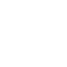

In [8]:
Image(filename = 'tree.png')